In [1]:
import wandb
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme()
sns.set_context('paper')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [43]:
import os
import sys
import copy
from pprint import pprint

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.models import CHNN
from src.systems.chain_pendulum import ChainPendulum
from src.train.ensemble_trainer import DeepEnsembleTrainer

dump_dir = os.path.abspath('../.log')

def parse_dump(dump):
    ts = dump.get('ts')
#     z0_orig = dump.get('z0_orig')
    true_zt = dump.get('true_zt')
#     true_zt_chaos = dump.get('true_zt_chaos')
    pred_zt = dump.get('pred_zt')

    return ts, true_zt, pred_zt

def download_runs_sweep(run_ids):
    api = wandb.Api()
    for run_id in run_ids:
        download_root = os.path.join(dump_dir, run_id)
        run = api.run("ngruver/physics-uncertainty-exps/{}".format(run_id))
        
        for f in run.files():
            if f.name != 'data.pt' and f.name != 'model.pt':
                continue
        
            fpath = os.path.join(download_root, f.name)
            if not os.path.isfile(fpath):
                f.download(root=download_root)
                
            if f.name == 'data.pt':
                data = torch.load(fpath)
            else:
                model = torch.load(fpath, map_location=torch.device('cpu'))
            
        yield run.name, run.config, model, parse_dump(data)

de_run_id = ["1axj7lqk"]

for _, cfg, model_dict, (ts, true_zt, pred_zt) in download_runs_sweep(de_run_id):
    pass

cfg.pop('uq_type')
cfg.pop('C')

body = ChainPendulum(cfg.get('num_bodies', 3))
trainer = DeepEnsembleTrainer(**cfg, network=CHNN, body=body, ensemble_size=10, n_systems=5000, C=5)

Generating 5000 more chunks
5000 total trajectories generated for train


In [ ]:
def get_preds(model, loader):
    preds = []
    for (z0, ts), true_zs in loader:
        with torch.no_grad():
            xp0 = model.to_pos_momentum(z0)
            t0 = ts[0,0]
            preds.append(model.dynamics(t0,xp0))
    preds = torch.cat(preds, dim=0)
    return preds

def get_ensemble_preds(ensemble, loader):
    preds = []
    for model in ensemble:
        preds.append(get_preds(model, loader).flatten())
    preds = torch.stack(preds, dim=0)
    return preds
        
log_dir = os.path.join(os.environ["LOGDIR"], "CHNN_ensembles")

train_loader = copy.deepcopy(trainer._trainers[0].dataloaders["train"])
test_loader = copy.deepcopy(trainer._trainers[0].dataloaders["test"])

train_preds = []
test_preds = []

train_preds.append(get_ensemble_preds(trainer.ensemble, train_loader))
test_preds.append(get_ensemble_preds(trainer.ensemble, test_loader))

for epoch_step in range(100):
    save_fn = "ensemble_epoch_{}.pt".format(5 * epoch_step)
    
    if False:# os.path.exists(save_fn):
        ensemble_dict = torch.load(save_fn)
        trainer.ensemble.load_state_dict(ensemble_dict)
    else:
        trainer.train(1)
        torch.save(trainer.ensemble.state_dict(), save_fn)
    
    train_preds.append(get_ensemble_preds(trainer.ensemble, train_loader))
    test_preds.append(get_ensemble_preds(trainer.ensemble, test_loader))

train_preds = torch.stack(train_preds, dim=0)
test_preds = torch.stack(test_preds, dim=0)

print(train_preds.size())
print(test_preds.size())

/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


   Minibatch_Loss  Train_MAE    lr0  nfe  test_MAE
0        0.128645    0.13125  0.003  0.0  0.131344


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
19             NaN   0.056456  0.002997  0.347826  0.056881


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


   Minibatch_Loss  Train_MAE    lr0  nfe  test_MAE
0        0.138609   0.137005  0.003  0.0  0.136295


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
19             NaN   0.060783  0.002997  0.347826  0.059069


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


   Minibatch_Loss  Train_MAE    lr0  nfe  test_MAE
0        0.134802   0.134845  0.003  0.0  0.134179


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
19             NaN   0.054846  0.002997  0.347826  0.053059


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


   Minibatch_Loss  Train_MAE    lr0  nfe  test_MAE
0         0.14233   0.137814  0.003  0.0  0.137671


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
19             NaN   0.062054  0.002997  0.347826  0.060628


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


   Minibatch_Loss  Train_MAE    lr0  nfe  test_MAE
0        0.127304   0.133393  0.003  0.0  0.132819


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
19             NaN   0.056631  0.002997  0.347826  0.055028


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


   Minibatch_Loss  Train_MAE    lr0  nfe  test_MAE
0        0.133454    0.13311  0.003  0.0  0.132965


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
19             NaN   0.057523  0.002997  0.347826   0.05596


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


   Minibatch_Loss  Train_MAE    lr0  nfe  test_MAE
0        0.145713   0.142743  0.003  0.0   0.14145


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
19             NaN   0.061725  0.002997  0.347826  0.059481


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


   Minibatch_Loss  Train_MAE    lr0  nfe  test_MAE
0        0.134983   0.134182  0.003  0.0   0.13428


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
19             NaN   0.059825  0.002997  0.347826  0.058509


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


   Minibatch_Loss  Train_MAE    lr0  nfe  test_MAE
0        0.126397   0.131332  0.003  0.0  0.131327


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
19             NaN   0.054974  0.002997  0.347826  0.053369


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


   Minibatch_Loss  Train_MAE    lr0  nfe  test_MAE
0        0.135785   0.142084  0.003  0.0  0.141088


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
19             NaN   0.058981  0.002997  0.347826  0.056728


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
20        0.054849   0.056456  0.002997  0.225352  0.056881


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
39             NaN   0.023898  0.002989  0.136752  0.024383


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
20        0.056142   0.060783  0.002997  0.225352  0.059069


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
39             NaN   0.023214  0.002989  0.136752  0.021148


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
20        0.051825   0.054846  0.002997  0.225352  0.053059


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
39             NaN   0.025361  0.002989  0.136752  0.023325


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
20         0.06418   0.062054  0.002997  0.225352  0.060628


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
39             NaN   0.025373  0.002989  0.136752  0.023746


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
20        0.057194   0.056631  0.002997  0.225352  0.055028


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
39             NaN   0.022451  0.002989  0.136752   0.02064


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
20        0.054121   0.057523  0.002997  0.225352   0.05596


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
39             NaN   0.022797  0.002989  0.136752  0.020712


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
20        0.064139   0.061725  0.002997  0.225352  0.059481


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
39             NaN   0.027709  0.002989  0.136752  0.026252


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
20        0.060355   0.059825  0.002997  0.225352  0.058509


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
39             NaN   0.024562  0.002989  0.136752  0.022406


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
20        0.057525   0.054974  0.002997  0.225352  0.053369


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
39             NaN   0.021118  0.002989  0.136752  0.019026


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
20        0.056739   0.058981  0.002997  0.225352  0.056728


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
39             NaN    0.02244  0.002989  0.136752  0.020719


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
40        0.027285   0.023898  0.002989  0.112676  0.024383


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
59             NaN   0.009981  0.002974  0.085106  0.010051


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
40        0.020662   0.023214  0.002989  0.112676  0.021148


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
59             NaN   0.006432  0.002974  0.085106    0.0052


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
40        0.025496   0.025361  0.002989  0.112676  0.023325


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
59             NaN   0.011677  0.002974  0.085106   0.01055


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
40        0.022987   0.025373  0.002989  0.112676  0.023746


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
59             NaN   0.008531  0.002974  0.085106  0.007228


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
40        0.021764   0.022451  0.002989  0.112676   0.02064


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
59             NaN   0.007241  0.002974  0.085106   0.00605


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
40        0.022309   0.022797  0.002989  0.112676  0.020712


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
59             NaN   0.008448  0.002974  0.085106  0.007326


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
40        0.030395   0.027709  0.002989  0.112676  0.026252


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
59             NaN   0.009198  0.002974  0.085106  0.008052


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
40        0.023221   0.024562  0.002989  0.112676  0.022406


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
59             NaN   0.013082  0.002974  0.085106  0.012142


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
40        0.021221   0.021118  0.002989  0.112676  0.019026


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
59             NaN   0.010092  0.002974  0.085106  0.009079


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
40        0.023687    0.02244  0.002989  0.112676  0.020719


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
59             NaN   0.008043  0.002974  0.085106  0.006831


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
60        0.009552   0.009981  0.002974  0.075117  0.010051


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
79             NaN   0.011483  0.002954  0.061776   0.01134


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
60        0.004979   0.006432  0.002974  0.075117    0.0052


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
79             NaN   0.008667  0.002954  0.061776  0.007661


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
60        0.012923   0.011677  0.002974  0.075117   0.01055


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
79             NaN   0.008076  0.002954  0.061776  0.007173


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
60        0.007019   0.008531  0.002974  0.075117  0.007228


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
79             NaN   0.013038  0.002954  0.061776  0.012272


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
60        0.008029   0.007241  0.002974  0.075117   0.00605


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
79             NaN   0.007022  0.002954  0.061776  0.006177


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
60        0.007332   0.008448  0.002974  0.075117  0.007326


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
79             NaN    0.00595  0.002954  0.061776  0.005056


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
60        0.009814   0.009198  0.002974  0.075117  0.008052


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
79             NaN   0.009858  0.002954  0.061776  0.009113


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
60        0.012596   0.013082  0.002974  0.075117  0.012142


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
79             NaN   0.008437  0.002954  0.061776  0.007622


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
60        0.010897   0.010092  0.002974  0.075117  0.009079


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
79             NaN   0.011891  0.002954  0.061776  0.011192


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
60         0.00673   0.008043  0.002974  0.075117  0.006831


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
79             NaN   0.008551  0.002954  0.061776  0.007407


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
80        0.010448   0.011483  0.002954  0.056338   0.01134


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
99             NaN   0.004318  0.002928  0.048485  0.004275


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
80        0.008616   0.008667  0.002954  0.056338  0.007661


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
99             NaN   0.008961  0.002928  0.048485  0.008033


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
80        0.007459   0.008076  0.002954  0.056338  0.007173


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
99             NaN   0.004579  0.002928  0.048485  0.003612


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
80        0.013741   0.013038  0.002954  0.056338  0.012272


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
99             NaN   0.007496  0.002928  0.048485  0.006523


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
80        0.006698   0.007022  0.002954  0.056338  0.006177


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
99             NaN   0.008701  0.002928  0.048485   0.00809


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
80        0.007118    0.00595  0.002954  0.056338  0.005056


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
99             NaN    0.00635  0.002928  0.048485  0.005471


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
80        0.008735   0.009858  0.002954  0.056338  0.009113


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
99             NaN    0.00576  0.002928  0.048485  0.004937


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
80        0.009469   0.008437  0.002954  0.056338  0.007622


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
99             NaN   0.006473  0.002928  0.048485   0.00555


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
80        0.011586   0.011891  0.002954  0.056338  0.011192


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
99             NaN   0.006408  0.002928  0.048485  0.005434


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
80        0.009358   0.008551  0.002954  0.056338  0.007407


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
99             NaN   0.005479  0.002928  0.048485  0.004556


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
100        0.005137   0.004318  0.002928  0.04507  0.004275


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0     nfe  test_MAE
119             NaN    0.00415  0.002896  0.0399  0.003951


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
100        0.008492   0.008961  0.002928  0.04507  0.008033


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0     nfe  test_MAE
119             NaN   0.005197  0.002896  0.0399  0.004519


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
100        0.004282   0.004579  0.002928  0.04507  0.003612


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0     nfe  test_MAE
119             NaN   0.007804  0.002896  0.0399  0.007201


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
100        0.007844   0.007496  0.002928  0.04507  0.006523


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0     nfe  test_MAE
119             NaN    0.00657  0.002896  0.0399   0.00584


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
100        0.009036   0.008701  0.002928  0.04507   0.00809


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0     nfe  test_MAE
119             NaN     0.0053  0.002896  0.0399  0.004758


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
100         0.00639    0.00635  0.002928  0.04507  0.005471


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0     nfe  test_MAE
119             NaN   0.011612  0.002896  0.0399   0.01117


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
100        0.005967    0.00576  0.002928  0.04507  0.004937


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0     nfe  test_MAE
119             NaN   0.007692  0.002896  0.0399  0.007197


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
100        0.006886   0.006473  0.002928  0.04507   0.00555


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0     nfe  test_MAE
119             NaN   0.004864  0.002896  0.0399   0.00407


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
100        0.005695   0.006408  0.002928  0.04507  0.005434


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0     nfe  test_MAE
119             NaN   0.006088  0.002896  0.0399  0.005488


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
100        0.005828   0.005479  0.002928  0.04507  0.004556


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0     nfe  test_MAE
119             NaN   0.005767  0.002896  0.0399  0.005108


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
120        0.003867    0.00415  0.002896  0.037559  0.003951


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
139             NaN   0.004043  0.002859  0.033898  0.003734


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
120        0.004701   0.005197  0.002896  0.037559  0.004519


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
139             NaN   0.006274  0.002859  0.033898  0.005826


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
120        0.008265   0.007804  0.002896  0.037559  0.007201


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
139             NaN   0.004606  0.002859  0.033898  0.004099


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
120        0.006265    0.00657  0.002896  0.037559   0.00584


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
139             NaN   0.006074  0.002859  0.033898  0.005644


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
120        0.006155     0.0053  0.002896  0.037559  0.004758


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
139             NaN   0.004473  0.002859  0.033898  0.004158


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
120        0.011377   0.011612  0.002896  0.037559   0.01117


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
139             NaN   0.008897  0.002859  0.033898  0.008449


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
120        0.007602   0.007691  0.002896  0.037559  0.007197


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
139             NaN   0.006938  0.002859  0.033898  0.006284


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
120        0.004221   0.004864  0.002896  0.037559   0.00407


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
139             NaN   0.003919  0.002859  0.033898  0.003214


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
120        0.006629   0.006088  0.002896  0.037559  0.005488


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
139             NaN     0.0037  0.002859  0.033898  0.003205


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
120        0.005318   0.005767  0.002896  0.037559  0.005108


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
139             NaN   0.007615  0.002859  0.033898  0.007254


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
140        0.003849   0.004043  0.002859  0.032193  0.003734


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
159             NaN   0.003297  0.002817  0.029466  0.003194


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
140        0.006661   0.006274  0.002859  0.032193  0.005826


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
159             NaN   0.003495  0.002817  0.029466  0.003104


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
140        0.004137   0.004606  0.002859  0.032193  0.004099


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
159             NaN   0.004683  0.002817  0.029466  0.004278


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
140        0.005334   0.006074  0.002859  0.032193  0.005644


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
159             NaN   0.002927  0.002817  0.029466  0.002463


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
140        0.004165   0.004473  0.002859  0.032193  0.004158


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
159             NaN   0.009581  0.002817  0.029466  0.009534


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
140        0.008715   0.008897  0.002859  0.032193  0.008449


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
159             NaN   0.005096  0.002817  0.029466  0.004621


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
140        0.006291   0.006938  0.002859  0.032193  0.006284


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
159             NaN   0.005166  0.002817  0.029466   0.00494


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
140        0.003116   0.003919  0.002859  0.032193  0.003214


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
159             NaN   0.005835  0.002817  0.029466  0.005355


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
140           0.003     0.0037  0.002859  0.032193  0.003205


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
159             NaN   0.005593  0.002817  0.029466  0.005274


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
140        0.007368   0.007615  0.002859  0.032193  0.007254


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
159             NaN   0.005499  0.002817  0.029466  0.005167


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
160        0.004467   0.003297  0.002817  0.028169  0.003194


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
179             NaN   0.005688  0.002769  0.026059  0.005504


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
160        0.004484   0.003495  0.002817  0.028169  0.003104


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
179             NaN   0.004789  0.002769  0.026059  0.004502


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
160        0.004465   0.004683  0.002817  0.028169  0.004278


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
179             NaN    0.00356  0.002769  0.026059  0.003232


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
160        0.003364   0.002927  0.002817  0.028169  0.002463


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
179             NaN   0.003396  0.002769  0.026059  0.002999


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
160        0.009696   0.009582  0.002817  0.028169  0.009534


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
179             NaN   0.005067  0.002769  0.026059  0.004759


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
160        0.005702   0.005096  0.002817  0.028169  0.004621


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
179             NaN   0.004859  0.002769  0.026059  0.004523


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
160        0.006064   0.005166  0.002817  0.028169   0.00494


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
179             NaN   0.004012  0.002769  0.026059  0.003592


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
160        0.005313   0.005835  0.002817  0.028169  0.005355


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
179             NaN   0.003495  0.002769  0.026059  0.003185


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
160        0.006001   0.005593  0.002817  0.028169  0.005274


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
179             NaN   0.005578  0.002769  0.026059  0.005358


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
160        0.005638   0.005499  0.002817  0.028169  0.005167


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
179             NaN   0.009354  0.002769  0.026059  0.009089


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
180        0.005139   0.005688  0.002769  0.025039  0.005504


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
199             NaN   0.003556  0.002716  0.023358   0.00328


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
180        0.004125   0.004789  0.002769  0.025039  0.004502


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
199             NaN   0.007949  0.002716  0.023358  0.007977


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
180         0.00411    0.00356  0.002769  0.025039  0.003232


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
199             NaN   0.003375  0.002716  0.023358  0.003168


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
180        0.005013   0.003396  0.002769  0.025039  0.002999


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
199             NaN    0.00452  0.002716  0.023358  0.004066


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
180        0.006366   0.005067  0.002769  0.025039  0.004759


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
199             NaN   0.004398  0.002716  0.023358  0.004268


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
180        0.005093   0.004859  0.002769  0.025039  0.004523


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
199             NaN   0.009159  0.002716  0.023358  0.009047


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
180        0.003456   0.004012  0.002769  0.025039  0.003592


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
199             NaN   0.009526  0.002716  0.023358  0.009359


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
180        0.004319   0.003496  0.002769  0.025039  0.003185


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
199             NaN   0.006169  0.002716  0.023358  0.005981


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
180        0.005124   0.005578  0.002769  0.025039  0.005358


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
199             NaN   0.004212  0.002716  0.023358  0.003869


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
180        0.008417   0.009354  0.002769  0.025039  0.009089


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
199             NaN   0.006913  0.002716  0.023358  0.006696


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
200        0.003273   0.003557  0.002716  0.022535   0.00328


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
219             NaN   0.006817  0.002659  0.021164  0.006584


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
200        0.007521   0.007949  0.002716  0.022535  0.007977


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
219             NaN    0.00342  0.002659  0.021164  0.003143


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
200         0.00349   0.003374  0.002716  0.022535  0.003168


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
219             NaN   0.003986  0.002659  0.021164  0.003891


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
200        0.004224    0.00452  0.002716  0.022535  0.004066


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
219             NaN   0.005525  0.002659  0.021164   0.00536


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
200        0.004179   0.004398  0.002716  0.022535  0.004268


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
219             NaN   0.005628  0.002659  0.021164  0.005505


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
200        0.009115   0.009159  0.002716  0.022535  0.009047


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
219             NaN   0.003353  0.002659  0.021164    0.0031


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
200        0.009204   0.009526  0.002716  0.022535  0.009359


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
219             NaN   0.004819  0.002659  0.021164  0.004555


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
200        0.005563   0.006169  0.002716  0.022535  0.005981


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
219             NaN   0.005171  0.002659  0.021164  0.004956


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
200        0.005308   0.004212  0.002716  0.022535  0.003869


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
219             NaN   0.004257  0.002659  0.021164  0.003985


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
200        0.006896   0.006913  0.002716  0.022535  0.006696


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
219             NaN   0.003449  0.002659  0.021164  0.003287


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
220        0.006934   0.006817  0.002659  0.020487  0.006584


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
239             NaN   0.003762  0.002597  0.019347  0.003624


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
220        0.003393    0.00342  0.002659  0.020487  0.003143


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
239             NaN   0.003675  0.002597  0.019347   0.00343


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
220        0.004396   0.003986  0.002659  0.020487  0.003891


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
239             NaN   0.002993  0.002597  0.019347  0.002807


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
220        0.005555   0.005525  0.002659  0.020487   0.00536


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
239             NaN   0.005472  0.002597  0.019347  0.005467


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
220        0.005994   0.005628  0.002659  0.020487  0.005505


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
239             NaN   0.002419  0.002597  0.019347  0.002249


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
220        0.003311   0.003353  0.002659  0.020487    0.0031


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
239             NaN   0.002721  0.002597  0.019347   0.00258


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
220        0.005564   0.004819  0.002659  0.020487  0.004555


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
239             NaN   0.003958  0.002597  0.019347  0.003658


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
220        0.004825    0.00517  0.002659  0.020487  0.004956


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
239             NaN    0.00546  0.002597  0.019347  0.005188


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
220         0.00396   0.004257  0.002659  0.020487  0.003985


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
239             NaN   0.005117  0.002597  0.019347  0.004945


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
220        0.003122   0.003449  0.002659  0.020487  0.003287


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
239             NaN   0.003986  0.002597  0.019347  0.003839


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
240         0.00346   0.003762  0.002597  0.018779  0.003624


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
259             NaN   0.003433  0.00253  0.017817  0.003317


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
240        0.004671   0.003675  0.002597  0.018779   0.00343


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
259             NaN   0.005483  0.00253  0.017817  0.005311


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
240        0.004073   0.002993  0.002597  0.018779  0.002807


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
259             NaN   0.004747  0.00253  0.017817  0.004632


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
240        0.005783   0.005472  0.002597  0.018779  0.005467


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
259             NaN   0.005215  0.00253  0.017817  0.004956


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
240        0.002173   0.002419  0.002597  0.018779  0.002249


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
259             NaN   0.002271  0.00253  0.017817  0.002026


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
240        0.002726   0.002721  0.002597  0.018779   0.00258


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
259             NaN   0.002728  0.00253  0.017817  0.002549


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
240        0.003597   0.003958  0.002597  0.018779  0.003658


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
259             NaN    0.00274  0.00253  0.017817   0.00256


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
240        0.005193    0.00546  0.002597  0.018779  0.005188


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
259             NaN   0.004973  0.00253  0.017817  0.004912


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
240        0.005012   0.005117  0.002597  0.018779  0.004945


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
259             NaN   0.007076  0.00253  0.017817  0.006986


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
240        0.004081   0.003986  0.002597  0.018779  0.003839


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
259             NaN   0.014597  0.00253  0.017817  0.014756


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
260        0.003774   0.003433  0.00253  0.017335  0.003317


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
279             NaN   0.002514  0.00246  0.016512    0.0023


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
260        0.005283   0.005483  0.00253  0.017335  0.005311


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
279             NaN   0.007081  0.00246  0.016512  0.007058


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
260        0.004488   0.004747  0.00253  0.017335  0.004632


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
279             NaN   0.002085  0.00246  0.016512  0.001882


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
260        0.004995   0.005215  0.00253  0.017335  0.004956


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
279             NaN   0.003172  0.00246  0.016512  0.003069


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
260        0.001916   0.002271  0.00253  0.017335  0.002026


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
279             NaN   0.002054  0.00246  0.016512  0.001926


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
260        0.002808   0.002728  0.00253  0.017335  0.002549


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
279             NaN   0.002421  0.00246  0.016512  0.002254


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
260        0.003101    0.00274  0.00253  0.017335   0.00256


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
279             NaN    0.00258  0.00246  0.016512  0.002379


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
260        0.004872   0.004973  0.00253  0.017335  0.004912


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
279             NaN   0.007969  0.00246  0.016512  0.007851


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
260        0.007041   0.007076  0.00253  0.017335  0.006986


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
279             NaN   0.005736  0.00246  0.016512  0.005564


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
260         0.01491   0.014597  0.00253  0.017335  0.014756


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
279             NaN    0.00419  0.00246  0.016512  0.004008


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
280         0.00216   0.002514  0.00246  0.016097    0.0023


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
299             NaN   0.003126  0.002385  0.015385  0.002983


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
280        0.007558   0.007081  0.00246  0.016097  0.007058


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
299             NaN   0.004987  0.002385  0.015385  0.004892


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
280        0.001741   0.002085  0.00246  0.016097  0.001882


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
299             NaN   0.002894  0.002385  0.015385  0.002682


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
280        0.003183   0.003172  0.00246  0.016097  0.003069


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
299             NaN   0.003281  0.002385  0.015385   0.00309


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
280        0.002999   0.002054  0.00246  0.016097  0.001926


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
299             NaN   0.006072  0.002385  0.015385  0.006042


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
280        0.002114   0.002421  0.00246  0.016097  0.002254


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
299             NaN   0.006437  0.002385  0.015385   0.00625


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
280        0.003054    0.00258  0.00246  0.016097  0.002379


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
299             NaN   0.003639  0.002385  0.015385  0.003552


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
280        0.008254   0.007969  0.00246  0.016097  0.007851


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
299             NaN   0.004208  0.002385  0.015385   0.00406


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
280        0.005808   0.005735  0.00246  0.016097  0.005564


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
299             NaN   0.003229  0.002385  0.015385  0.003058


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
280        0.004162    0.00419  0.00246  0.016097  0.004008


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
299             NaN   0.003902  0.002385  0.015385  0.003587


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
300        0.002833   0.003126  0.002385  0.015023  0.002983


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
319             NaN   0.002718  0.002308  0.014401  0.002664


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
300        0.004628   0.004987  0.002385  0.015023  0.004892


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
319             NaN   0.003021  0.002308  0.014401  0.002953


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
300        0.002721   0.002894  0.002385  0.015023  0.002682


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
319             NaN   0.002937  0.002308  0.014401  0.002884


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
300        0.003443   0.003281  0.002385  0.015023   0.00309


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
319             NaN   0.004355  0.002308  0.014401  0.004147


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
300         0.00562   0.006072  0.002385  0.015023  0.006042


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
319             NaN   0.005972  0.002308  0.014401  0.005885


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
300        0.006248   0.006437  0.002385  0.015023   0.00625


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
319             NaN   0.002341  0.002308  0.014401  0.002195


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
300        0.003221   0.003639  0.002385  0.015023  0.003552


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
319             NaN   0.004879  0.002308  0.014401  0.004799


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
300        0.004856   0.004208  0.002385  0.015023   0.00406


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
319             NaN   0.003696  0.002308  0.014401  0.003559


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
300        0.003059   0.003229  0.002385  0.015023  0.003058


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
319             NaN   0.003973  0.002308  0.014401  0.003821


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
300        0.004186   0.003902  0.002385  0.015023  0.003587


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
319             NaN   0.002718  0.002308  0.014401  0.002538


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
320        0.002793   0.002718  0.002308  0.014085  0.002664


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
339             NaN   0.002643  0.002227  0.013536  0.002507


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
320        0.002785   0.003021  0.002308  0.014085  0.002953


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
339             NaN   0.002124  0.002227  0.013536   0.00201


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
320        0.002962   0.002937  0.002308  0.014085  0.002884


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
339             NaN   0.004014  0.002227  0.013536  0.003922


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
320        0.005546   0.004355  0.002308  0.014085  0.004147


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
339             NaN   0.005148  0.002227  0.013536  0.004883


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
320        0.006301   0.005972  0.002308  0.014085  0.005885


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
339             NaN   0.004629  0.002227  0.013536   0.00441


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
320        0.002036   0.002341  0.002308  0.014085  0.002195


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
339             NaN   0.006968  0.002227  0.013536  0.006815


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
320        0.004544   0.004878  0.002308  0.014085  0.004799


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
339             NaN   0.003293  0.002227  0.013536  0.003144


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
320        0.003671   0.003697  0.002308  0.014085  0.003559


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
339             NaN   0.003356  0.002227  0.013536  0.003191


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
320        0.003581   0.003973  0.002308  0.014085  0.003821


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
339             NaN   0.002436  0.002227  0.013536  0.002274


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
320        0.002433   0.002718  0.002308  0.014085  0.002538


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
339             NaN   0.002501  0.002227  0.013536  0.002406


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
340        0.002801   0.002643  0.002227  0.013256  0.002507


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
359             NaN   0.002433  0.002143  0.012769  0.002339


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
340        0.001807   0.002124  0.002227  0.013256   0.00201


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
359             NaN   0.003882  0.002143  0.012769  0.003812


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
340        0.003934   0.004014  0.002227  0.013256  0.003922


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
359             NaN   0.002655  0.002143  0.012769  0.002475


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
340        0.006014   0.005148  0.002227  0.013256  0.004883


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
359             NaN   0.003986  0.002143  0.012769  0.003918


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
340        0.004449   0.004629  0.002227  0.013256   0.00441


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
359             NaN   0.003521  0.002143  0.012769  0.003349


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
340        0.006594   0.006968  0.002227  0.013256  0.006815


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
359             NaN   0.005872  0.002143  0.012769  0.005776


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
340        0.003324   0.003293  0.002227  0.013256  0.003144


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
359             NaN   0.006412  0.002143  0.012769   0.00629


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
340        0.003884   0.003356  0.002227  0.013256  0.003191


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
359             NaN   0.003967  0.002143  0.012769  0.003835


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
340        0.004171   0.002436  0.002227  0.013256  0.002274


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
359             NaN   0.003264  0.002143  0.012769  0.003147


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
340        0.002108   0.002501  0.002227  0.013256  0.002406


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
359             NaN   0.002021  0.002143  0.012769  0.001934


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
360        0.002246   0.002433  0.002143  0.01252  0.002339


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
379             NaN    0.00529  0.002057  0.012085  0.005178


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
360        0.003746   0.003882  0.002143  0.01252  0.003812


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
379             NaN   0.001768  0.002057  0.012085   0.00164


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
360        0.002241   0.002654  0.002143  0.01252  0.002475


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
379             NaN   0.002219  0.002057  0.012085  0.002072


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
360        0.003637   0.003986  0.002143  0.01252  0.003918


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
379             NaN   0.004258  0.002057  0.012085  0.004319


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
360        0.002971   0.003521  0.002143  0.01252  0.003349


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
379             NaN   0.003387  0.002057  0.012085  0.003279


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
360        0.005928   0.005872  0.002143  0.01252  0.005776


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
379             NaN   0.002533  0.002057  0.012085  0.002402


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
360        0.007111   0.006412  0.002143  0.01252   0.00629


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
379             NaN   0.001817  0.002057  0.012085  0.001735


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
360        0.003782   0.003967  0.002143  0.01252  0.003835


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
379             NaN   0.004316  0.002057  0.012085  0.004287


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
360        0.003163   0.003264  0.002143  0.01252  0.003147


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
379             NaN   0.003273  0.002057  0.012085   0.00316


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
360        0.001919   0.002021  0.002143  0.01252  0.001934


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
379             NaN   0.004327  0.002057  0.012085    0.0043


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
380        0.005288    0.00529  0.002057  0.011861  0.005178


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
399             NaN   0.002839  0.001968  0.01147  0.002706


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
380        0.001749   0.001768  0.002057  0.011861   0.00164


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
399             NaN   0.002427  0.001968  0.01147  0.002313


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
380        0.002097   0.002219  0.002057  0.011861  0.002072


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
399             NaN   0.001467  0.001968  0.01147  0.001398


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
380        0.003818   0.004258  0.002057  0.011861  0.004319


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
399             NaN   0.002905  0.001968  0.01147  0.002776


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
380        0.002989   0.003387  0.002057  0.011861  0.003279


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
399             NaN   0.002722  0.001968  0.01147  0.002647


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
380        0.002527   0.002533  0.002057  0.011861  0.002402


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
399             NaN   0.002345  0.001968  0.01147  0.002221


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
380        0.002485   0.001817  0.002057  0.011861  0.001735


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
399             NaN   0.002738  0.001968  0.01147  0.002668


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
380        0.004136   0.004316  0.002057  0.011861  0.004287


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
399             NaN   0.003141  0.001968  0.01147  0.003057


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
380        0.002945   0.003273  0.002057  0.011861   0.00316


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
399             NaN   0.002085  0.001968  0.01147  0.001962


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
380        0.004152   0.004326  0.002057  0.011861    0.0043


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
399             NaN   0.003453  0.001968  0.01147  0.003424


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
400        0.002673   0.002839  0.001968  0.011268  0.002706


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
419             NaN   0.001664  0.001878  0.010914   0.00155


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
400        0.002233   0.002427  0.001968  0.011268  0.002313


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
419             NaN   0.001446  0.001878  0.010914  0.001352


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
400        0.001172   0.001467  0.001968  0.011268  0.001398


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
419             NaN    0.00643  0.001878  0.010914  0.006445


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
400        0.002993   0.002905  0.001968  0.011268  0.002776


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
419             NaN   0.004218  0.001878  0.010914  0.004122


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
400        0.002738   0.002722  0.001968  0.011268  0.002647


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
419             NaN   0.004111  0.001878  0.010914  0.004071


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
400        0.002114   0.002345  0.001968  0.011268  0.002221


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
419             NaN   0.003301  0.001878  0.010914  0.003218


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
400        0.002569   0.002738  0.001968  0.011268  0.002668


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
419             NaN   0.002558  0.001878  0.010914  0.002553


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
400        0.003827   0.003141  0.001968  0.011268  0.003057


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
419             NaN   0.002168  0.001878  0.010914  0.001994


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
400        0.002029   0.002085  0.001968  0.011268  0.001962


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
419             NaN   0.004849  0.001878  0.010914  0.004856


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
400        0.003273   0.003453  0.001968  0.011268  0.003424


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
419             NaN   0.003699  0.001878  0.010914   0.00365


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
420        0.001356   0.001664  0.001878  0.010731   0.00155


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
439             NaN   0.003174  0.001786  0.01041  0.003066


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
420        0.001123   0.001446  0.001878  0.010731  0.001352


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
439             NaN   0.002787  0.001786  0.01041  0.002736


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
420        0.006518    0.00643  0.001878  0.010731  0.006445


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
439             NaN   0.003106  0.001786  0.01041  0.003016


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
420         0.00409   0.004218  0.001878  0.010731  0.004122


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
439             NaN   0.001891  0.001786  0.01041  0.001834


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
420        0.003956   0.004111  0.001878  0.010731  0.004071


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
439             NaN   0.003213  0.001786  0.01041  0.003169


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
420        0.004006   0.003301  0.001878  0.010731  0.003218


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
439             NaN   0.002076  0.001786  0.01041  0.002007


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
420        0.003177   0.002558  0.001878  0.010731  0.002553


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
439             NaN   0.002581  0.001786  0.01041  0.002559


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
420        0.001819   0.002168  0.001878  0.010731  0.001994


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
439             NaN   0.003607  0.001786  0.01041  0.003526


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
420        0.004618   0.004848  0.001878  0.010731  0.004856


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
439             NaN   0.002725  0.001786  0.01041   0.00263


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
420        0.003367   0.003699  0.001878  0.010731   0.00365


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
439             NaN   0.002826  0.001786  0.01041  0.002783


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
440        0.002995   0.003174  0.001786  0.010243  0.003066


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
459             NaN   0.002859  0.001693  0.00995  0.002767


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
440        0.003786   0.002787  0.001786  0.010243  0.002736


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
459             NaN   0.003552  0.001693  0.00995  0.003426


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
440        0.003143   0.003107  0.001786  0.010243  0.003016


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
459             NaN   0.002308  0.001693  0.00995  0.002223


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
440        0.001627   0.001891  0.001786  0.010243  0.001834


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
459             NaN   0.002596  0.001693  0.00995  0.002576


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
440        0.002871   0.003213  0.001786  0.010243  0.003169


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
459             NaN   0.001802  0.001693  0.00995  0.001747


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
440        0.002702   0.002076  0.001786  0.010243  0.002007


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
459             NaN   0.001783  0.001693  0.00995    0.0017


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
440        0.002626   0.002581  0.001786  0.010243  0.002559


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
459             NaN    0.00251  0.001693  0.00995  0.002437


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
440        0.003296   0.003607  0.001786  0.010243  0.003526


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
459             NaN   0.002067  0.001693  0.00995  0.001977


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
440        0.002539   0.002725  0.001786  0.010243   0.00263


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
459             NaN    0.00231  0.001693  0.00995  0.002216


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
440        0.003541   0.002826  0.001786  0.010243  0.002783


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
459             NaN   0.003164  0.001693  0.00995  0.003101


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
460        0.003066   0.002858  0.001693  0.009798  0.002767


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
479             NaN   0.002318  0.001599  0.009529  0.002199


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
460        0.003448   0.003551  0.001693  0.009798  0.003426


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
479             NaN   0.001249  0.001599  0.009529  0.001189


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
460        0.002236   0.002308  0.001693  0.009798  0.002223


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
479             NaN   0.001203  0.001599  0.009529  0.001118


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
460        0.002436   0.002596  0.001693  0.009798  0.002576


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
479             NaN   0.001978  0.001599  0.009529  0.001882


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
460        0.001627   0.001802  0.001693  0.009798  0.001747


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
479             NaN    0.00263  0.001599  0.009529  0.002547


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
460        0.001494   0.001783  0.001693  0.009798    0.0017


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
479             NaN    0.00279  0.001599  0.009529  0.002751


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
460        0.002298    0.00251  0.001693  0.009798  0.002437


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
479             NaN   0.001942  0.001599  0.009529   0.00186


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
460         0.00195   0.002067  0.001693  0.009798  0.001977


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
479             NaN    0.00236  0.001599  0.009529  0.002284


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
460        0.002247    0.00231  0.001693  0.009798  0.002216


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
479             NaN   0.002154  0.001599  0.009529  0.002074


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
460        0.003662   0.003164  0.001693  0.009798  0.003101


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
479             NaN   0.002597  0.001599  0.009529  0.002599


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
480        0.002147   0.002318  0.001599  0.00939  0.002199


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
499             NaN   0.001823  0.001505  0.009143  0.001737


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
480         0.00096   0.001249  0.001599  0.00939  0.001189


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
499             NaN   0.002055  0.001505  0.009143  0.001995


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
480        0.000898   0.001203  0.001599  0.00939  0.001118


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
499             NaN   0.002005  0.001505  0.009143  0.001996


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
480        0.001945   0.001977  0.001599  0.00939  0.001882


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
499             NaN   0.001817  0.001505  0.009143  0.001686


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
480        0.002431    0.00263  0.001599  0.00939  0.002547


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
499             NaN   0.001426  0.001505  0.009143   0.00139


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
480        0.002514    0.00279  0.001599  0.00939  0.002751


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
499             NaN   0.001917  0.001505  0.009143  0.001858


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
480        0.001952   0.001942  0.001599  0.00939   0.00186


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
499             NaN   0.002182  0.001505  0.009143  0.002142


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
480        0.002825    0.00236  0.001599  0.00939  0.002284


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
499             NaN   0.001553  0.001505  0.009143  0.001493


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
480        0.001951   0.002154  0.001599  0.00939  0.002074


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
499             NaN   0.001816  0.001505  0.009143  0.001749


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
480        0.002503   0.002596  0.001599  0.00939  0.002599


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
499             NaN   0.001414  0.001505  0.009143  0.001348


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
500        0.002408   0.001823  0.001505  0.009014  0.001737


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
519             NaN    0.00453  0.001411  0.008786  0.004376


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
500        0.002118   0.002055  0.001505  0.009014  0.001995


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
519             NaN   0.002521  0.001411  0.008786  0.002414


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
500        0.002566   0.002005  0.001505  0.009014  0.001996


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
519             NaN    0.00279  0.001411  0.008786  0.002764


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
500        0.002159   0.001817  0.001505  0.009014  0.001686


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
519             NaN   0.002818  0.001411  0.008786  0.002761


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
500        0.001431   0.001426  0.001505  0.009014   0.00139


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
519             NaN   0.001659  0.001411  0.008786  0.001583


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
500        0.001673   0.001917  0.001505  0.009014  0.001858


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
519             NaN   0.004447  0.001411  0.008786  0.004442


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
500        0.001985   0.002182  0.001505  0.009014  0.002142


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
519             NaN    0.00171  0.001411  0.008786   0.00162


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
500         0.00139   0.001553  0.001505  0.009014  0.001493


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
519             NaN   0.003378  0.001411  0.008786  0.003319


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
500        0.001534   0.001816  0.001505  0.009014  0.001749


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
519             NaN   0.001676  0.001411  0.008786  0.001608


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
500        0.001166   0.001414  0.001505  0.009014  0.001348


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
519             NaN   0.004437  0.001411  0.008786  0.004482


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
520        0.005291    0.00453  0.001411  0.008667  0.004376


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
539             NaN   0.003161  0.001317  0.008457  0.003035


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
520        0.002411   0.002521  0.001411  0.008667  0.002414


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
539             NaN   0.001107  0.001317  0.008457  0.001023


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
520        0.003405    0.00279  0.001411  0.008667  0.002764


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
539             NaN   0.001843  0.001317  0.008457  0.001787


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
520        0.002817   0.002818  0.001411  0.008667  0.002761


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
539             NaN   0.002922  0.001317  0.008457   0.00283


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
520        0.001623   0.001659  0.001411  0.008667  0.001583


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
539             NaN   0.001741  0.001317  0.008457   0.00161


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
520         0.00431   0.004447  0.001411  0.008667  0.004442


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
539             NaN   0.002345  0.001317  0.008457  0.002277


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
520        0.001628    0.00171  0.001411  0.008667   0.00162


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
539             NaN   0.002318  0.001317  0.008457  0.002266


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
520        0.003164   0.003378  0.001411  0.008667  0.003319


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
539             NaN    0.00265  0.001317  0.008457  0.002681


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
520        0.001633   0.001676  0.001411  0.008667  0.001608


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
539             NaN   0.001057  0.001317  0.008457  0.000983


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
520        0.004474   0.004437  0.001411  0.008667  0.004482


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
539             NaN   0.002594  0.001317  0.008457  0.002637


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
540        0.003691    0.00316  0.001317  0.008346  0.003035


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
559             NaN   0.002034  0.001224  0.008151   0.00194


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
540        0.001597   0.001107  0.001317  0.008346  0.001023


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
559             NaN   0.001872  0.001224  0.008151  0.001779


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
540        0.001735   0.001843  0.001317  0.008346  0.001787


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
559             NaN   0.001627  0.001224  0.008151  0.001608


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
540        0.002655   0.002922  0.001317  0.008346   0.00283


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
559             NaN   0.003908  0.001224  0.008151  0.003936


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
540        0.001616   0.001741  0.001317  0.008346   0.00161


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
559             NaN   0.002135  0.001224  0.008151  0.002081


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
540        0.002029   0.002345  0.001317  0.008346  0.002277


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
559             NaN   0.002479  0.001224  0.008151  0.002463


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
540        0.002116   0.002318  0.001317  0.008346  0.002266


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
559             NaN   0.001396  0.001224  0.008151  0.001341


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
540        0.002446    0.00265  0.001317  0.008346  0.002681


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
559             NaN   0.002242  0.001224  0.008151  0.002233


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
540         0.00119   0.001057  0.001317  0.008346  0.000983


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
559             NaN   0.004364  0.001224  0.008151  0.004326


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
540        0.002331   0.002594  0.001317  0.008346  0.002637


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
559             NaN   0.001326  0.001224  0.008151  0.001269


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
560        0.001796   0.002034  0.001224  0.008048   0.00194


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
579             NaN   0.002555  0.001132  0.007866  0.002457


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
560        0.001821   0.001872  0.001224  0.008048  0.001779


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
579             NaN   0.000909  0.001132  0.007866   0.00085


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
560        0.001456   0.001627  0.001224  0.008048  0.001608


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
579             NaN    0.00192  0.001132  0.007866  0.001853


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
560        0.004476   0.003908  0.001224  0.008048  0.003936


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
579             NaN   0.002656  0.001132  0.007866  0.002631


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
560        0.001914   0.002135  0.001224  0.008048  0.002081


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
579             NaN   0.002515  0.001132  0.007866  0.002422


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
560        0.002242   0.002479  0.001224  0.008048  0.002463


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
579             NaN   0.002219  0.001132  0.007866  0.002159


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
560        0.001454   0.001396  0.001224  0.008048  0.001341


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
579             NaN   0.003062  0.001132  0.007866  0.003097


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
560        0.002068   0.002242  0.001224  0.008048  0.002233


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
579             NaN   0.001771  0.001132  0.007866  0.001714


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
560        0.004378   0.004364  0.001224  0.008048  0.004326


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
579             NaN   0.001902  0.001132  0.007866  0.001837


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
560        0.001076   0.001326  0.001224  0.008048  0.001269


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
579             NaN   0.002168  0.001132  0.007866  0.002102


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
580        0.002433   0.002555  0.001132  0.007771  0.002457


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
599             NaN   0.001827  0.001041  0.007601   0.00171


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
580        0.000672   0.000909  0.001132  0.007771   0.00085


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
599             NaN   0.001652  0.001041  0.007601  0.001585


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
580        0.001884    0.00192  0.001132  0.007771  0.001853


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
599             NaN   0.002157  0.001041  0.007601  0.002101


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
580        0.003201   0.002656  0.001132  0.007771  0.002631


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
599             NaN   0.001592  0.001041  0.007601  0.001564


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
580        0.002526   0.002515  0.001132  0.007771  0.002422


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
599             NaN   0.001775  0.001041  0.007601  0.001726


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
580        0.002436   0.002219  0.001132  0.007771  0.002159


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
599             NaN   0.001276  0.001041  0.007601  0.001192


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
580        0.003787   0.003062  0.001132  0.007771  0.003097


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
599             NaN   0.002527  0.001041  0.007601   0.00252


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
580        0.001884   0.001771  0.001132  0.007771  0.001714


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
599             NaN   0.001033  0.001041  0.007601  0.000986


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
580        0.001741   0.001902  0.001132  0.007771  0.001837


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
599             NaN   0.001898  0.001041  0.007601  0.001852


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
580        0.002223   0.002168  0.001132  0.007771  0.002102


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
599             NaN   0.000849  0.001041  0.007601  0.000807


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
600        0.001825   0.001827  0.001041  0.007512   0.00171


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
619             NaN   0.002167  0.000952  0.007353  0.002045


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
600        0.002591   0.001653  0.001041  0.007512  0.001585


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
619             NaN   0.002291  0.000952  0.007353  0.002286


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
600        0.002251   0.002157  0.001041  0.007512  0.002101


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
619             NaN     0.0012  0.000952  0.007353  0.001127


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
600        0.001927   0.001592  0.001041  0.007512  0.001564


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
619             NaN   0.001801  0.000952  0.007353  0.001755


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
600        0.001756   0.001775  0.001041  0.007512  0.001726


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
619             NaN   0.001794  0.000952  0.007353  0.001752


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
600        0.001034   0.001276  0.001041  0.007512  0.001192


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
619             NaN   0.000968  0.000952  0.007353  0.000908


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
600        0.002427   0.002527  0.001041  0.007512   0.00252


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
619             NaN   0.002408  0.000952  0.007353  0.002356


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
600        0.001634   0.001034  0.001041  0.007512  0.000986


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
619             NaN   0.001652  0.000952  0.007353  0.001607


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
600         0.00179   0.001898  0.001041  0.007512  0.001852


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
619             NaN   0.001118  0.000952  0.007353  0.001105


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
600        0.000604   0.000849  0.001041  0.007512  0.000807


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
619             NaN   0.001439  0.000952  0.007353  0.001394


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
620        0.001886   0.002167  0.000952  0.007269  0.002045


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
639             NaN   0.001823  0.000866  0.007121   0.00173


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
620        0.002182   0.002291  0.000952  0.007269  0.002286


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
639             NaN    0.00167  0.000866  0.007121  0.001664


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
620        0.000983     0.0012  0.000952  0.007269  0.001127


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
639             NaN   0.002221  0.000866  0.007121   0.00218


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
620        0.001615   0.001801  0.000952  0.007269  0.001755


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
639             NaN   0.001378  0.000866  0.007121  0.001307


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
620        0.001634   0.001794  0.000952  0.007269  0.001752


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
639             NaN   0.001317  0.000866  0.007121  0.001259


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
620        0.000864   0.000968  0.000952  0.007269  0.000908


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
639             NaN   0.001876  0.000866  0.007121  0.001848


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
620        0.002964   0.002408  0.000952  0.007269  0.002356


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
639             NaN   0.001388  0.000866  0.007121  0.001368


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
620        0.001332   0.001652  0.000952  0.007269  0.001607


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
639             NaN   0.001802  0.000866  0.007121  0.001738


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
620        0.000846   0.001117  0.000952  0.007269  0.001105


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
639             NaN   0.001026  0.000866  0.007121  0.000975


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
620        0.001183   0.001439  0.000952  0.007269  0.001394


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
639             NaN   0.001652  0.000866  0.007121  0.001639


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
640        0.001796   0.001823  0.000866  0.007042   0.00173


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
659             NaN   0.001147  0.000782  0.006903   0.00103


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
640         0.00156    0.00167  0.000866  0.007042  0.001664


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
659             NaN     0.0011  0.000782  0.006903  0.001075


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
640        0.001956   0.002221  0.000866  0.007042   0.00218


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
659             NaN   0.001304  0.000782  0.006903  0.001271


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
640        0.001295   0.001378  0.000866  0.007042  0.001307


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
659             NaN   0.001715  0.000782  0.006903    0.0017


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
640        0.001011   0.001317  0.000866  0.007042  0.001259


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
659             NaN    0.00122  0.000782  0.006903  0.001167


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
640         0.00184   0.001875  0.000866  0.007042  0.001848


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
659             NaN   0.001311  0.000782  0.006903  0.001282


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
640        0.001064   0.001388  0.000866  0.007042  0.001368


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
659             NaN   0.001221  0.000782  0.006903  0.001169


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
640        0.002309   0.001802  0.000866  0.007042  0.001738


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
659             NaN   0.001075  0.000782  0.006903  0.001049


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
640        0.000792   0.001026  0.000866  0.007042  0.000975


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
659             NaN   0.002057  0.000782  0.006903  0.001989


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
640        0.001345   0.001652  0.000866  0.007042  0.001639


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
659             NaN   0.002358  0.000782  0.006903  0.002301


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
660        0.000935   0.001147  0.000782  0.006829   0.00103


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE     lr0       nfe  test_MAE
679             NaN   0.001709  0.0007  0.006697  0.001597


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
660        0.000995     0.0011  0.000782  0.006829  0.001075


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE     lr0       nfe  test_MAE
679             NaN    0.00086  0.0007  0.006697  0.000807


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
660        0.001218   0.001304  0.000782  0.006829  0.001271


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE     lr0       nfe  test_MAE
679             NaN   0.001616  0.0007  0.006697  0.001562


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
660        0.001517   0.001715  0.000782  0.006829    0.0017


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE     lr0       nfe  test_MAE
679             NaN    0.00223  0.0007  0.006697  0.002183


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
660        0.001705    0.00122  0.000782  0.006829  0.001167


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE     lr0       nfe  test_MAE
679             NaN   0.001034  0.0007  0.006697  0.000973


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
660        0.001254   0.001311  0.000782  0.006829  0.001282


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE     lr0       nfe  test_MAE
679             NaN    0.00133  0.0007  0.006697  0.001311


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
660        0.001073   0.001221  0.000782  0.006829  0.001169


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE     lr0       nfe  test_MAE
679             NaN   0.003226  0.0007  0.006697  0.003251


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
660        0.001002   0.001075  0.000782  0.006829  0.001049


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE     lr0       nfe  test_MAE
679             NaN    0.00143  0.0007  0.006697   0.00143


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
660        0.002044   0.002057  0.000782  0.006829  0.001989


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE     lr0       nfe  test_MAE
679             NaN   0.001084  0.0007  0.006697  0.001057


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
660        0.002131   0.002358  0.000782  0.006829  0.002301


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE     lr0       nfe  test_MAE
679             NaN    0.00173  0.0007  0.006697  0.001662


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE     lr0       nfe  test_MAE
680        0.001553   0.001709  0.0007  0.006628  0.001597


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
699             NaN   0.001301  0.000622  0.006504  0.001186


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE     lr0       nfe  test_MAE
680        0.000559    0.00086  0.0007  0.006628  0.000807


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
699             NaN   0.000745  0.000622  0.006504   0.00069


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE     lr0       nfe  test_MAE
680        0.001553   0.001616  0.0007  0.006628  0.001562


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
699             NaN   0.000906  0.000622  0.006504  0.000871


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE     lr0       nfe  test_MAE
680        0.002161    0.00223  0.0007  0.006628  0.002183


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
699             NaN   0.001088  0.000622  0.006504  0.001061


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE     lr0       nfe  test_MAE
680         0.00139   0.001034  0.0007  0.006628  0.000973


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
699             NaN   0.000625  0.000622  0.006504  0.000578


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE     lr0       nfe  test_MAE
680        0.001204    0.00133  0.0007  0.006628  0.001311


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
699             NaN    0.00083  0.000622  0.006504  0.000772


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE     lr0       nfe  test_MAE
680        0.003109   0.003226  0.0007  0.006628  0.003251


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
699             NaN   0.001368  0.000622  0.006504  0.001363


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE     lr0       nfe  test_MAE
680        0.001274    0.00143  0.0007  0.006628   0.00143


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
699             NaN   0.001496  0.000622  0.006504  0.001462


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE     lr0       nfe  test_MAE
680        0.000924   0.001084  0.0007  0.006628  0.001057


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
699             NaN   0.000779  0.000622  0.006504  0.000723


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE     lr0       nfe  test_MAE
680        0.002268    0.00173  0.0007  0.006628  0.001662


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
699             NaN   0.000964  0.000622  0.006504   0.00094


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
700        0.001237   0.001301  0.000622  0.006439  0.001186


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
719             NaN   0.001409  0.000547  0.006322  0.001294


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
700        0.001165   0.000745  0.000622  0.006439   0.00069


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
719             NaN   0.000927  0.000547  0.006322  0.000887


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
700        0.000683   0.000906  0.000622  0.006439  0.000871


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
719             NaN   0.000836  0.000547  0.006322  0.000807


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
700        0.000931   0.001088  0.000622  0.006439  0.001061


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
719             NaN   0.001007  0.000547  0.006322  0.000986


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
700        0.000417   0.000625  0.000622  0.006439  0.000578


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
719             NaN   0.000948  0.000547  0.006322  0.000918


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
700        0.000589    0.00083  0.000622  0.006439  0.000772


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
719             NaN   0.000828  0.000547  0.006322  0.000798


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
700        0.001093   0.001368  0.000622  0.006439  0.001363


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
719             NaN   0.000839  0.000547  0.006322   0.00078


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
700        0.001233   0.001497  0.000622  0.006439  0.001462


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
719             NaN    0.00159  0.000547  0.006322  0.001578


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
700        0.000626   0.000779  0.000622  0.006439  0.000723


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
719             NaN   0.000853  0.000547  0.006322  0.000819


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
700        0.001082   0.000964  0.000622  0.006439   0.00094


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
719             NaN   0.000784  0.000547  0.006322  0.000746


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
720        0.001397   0.001409  0.000547  0.00626  0.001294


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
739             NaN   0.000919  0.000477  0.006149  0.000812


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
720        0.000621   0.000927  0.000547  0.00626  0.000887


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
739             NaN   0.000734  0.000477  0.006149  0.000689


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
720        0.000736   0.000836  0.000547  0.00626  0.000807


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
739             NaN   0.001213  0.000477  0.006149  0.001203


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
720        0.000897   0.001007  0.000547  0.00626  0.000986


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
739             NaN    0.00083  0.000477  0.006149  0.000779


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
720        0.000757   0.000948  0.000547  0.00626  0.000918


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
739             NaN   0.000651  0.000477  0.006149  0.000613


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
720        0.000573   0.000828  0.000547  0.00626  0.000798


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
739             NaN   0.000749  0.000477  0.006149  0.000732


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
720        0.001573   0.000839  0.000547  0.00626   0.00078


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
739             NaN    0.00072  0.000477  0.006149  0.000682


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
720         0.00146    0.00159  0.000547  0.00626  0.001578


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
739             NaN   0.001797  0.000477  0.006149  0.001803


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
720        0.001576   0.000853  0.000547  0.00626  0.000819


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
739             NaN   0.000816  0.000477  0.006149  0.000784


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
720        0.000577   0.000784  0.000547  0.00626  0.000746


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
739             NaN   0.000643  0.000477  0.006149  0.000608


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
740        0.001643   0.000919  0.000477  0.006091  0.000812


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
759             NaN   0.000708  0.00041  0.005986  0.000597


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
740        0.000498   0.000734  0.000477  0.006091  0.000689


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
759             NaN   0.000902  0.00041  0.005986   0.00086


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
740        0.000986   0.001213  0.000477  0.006091  0.001203


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
759             NaN   0.000761  0.00041  0.005986  0.000731


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
740        0.000636    0.00083  0.000477  0.006091  0.000779


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
759             NaN   0.001122  0.00041  0.005986  0.001075


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
740        0.001048   0.000651  0.000477  0.006091  0.000613


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
759             NaN    0.00085  0.00041  0.005986  0.000825


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
740        0.000622   0.000749  0.000477  0.006091  0.000732


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
759             NaN   0.000703  0.00041  0.005986  0.000687


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
740        0.001071    0.00072  0.000477  0.006091  0.000682


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
759             NaN   0.000688  0.00041  0.005986  0.000661


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
740        0.001622   0.001797  0.000477  0.006091  0.001803


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
759             NaN   0.001002  0.00041  0.005986  0.000974


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
740        0.000788   0.000816  0.000477  0.006091  0.000784


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
759             NaN   0.000907  0.00041  0.005986  0.000877


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
740        0.000831   0.000643  0.000477  0.006091  0.000608


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0       nfe  test_MAE
759             NaN   0.000784  0.00041  0.005986  0.000752


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0      nfe  test_MAE
760        0.000539   0.000708  0.00041  0.00593  0.000597


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
779             NaN   0.000635  0.000347  0.005831  0.000527


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0      nfe  test_MAE
760        0.000684   0.000902  0.00041  0.00593   0.00086


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
779             NaN   0.000661  0.000347  0.005831  0.000636


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0      nfe  test_MAE
760         0.00069   0.000761  0.00041  0.00593  0.000731


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
779             NaN   0.000687  0.000347  0.005831  0.000665


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0      nfe  test_MAE
760        0.001796   0.001122  0.00041  0.00593  0.001075


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
779             NaN   0.000682  0.000347  0.005831  0.000644


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0      nfe  test_MAE
760        0.000769    0.00085  0.00041  0.00593  0.000825


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
779             NaN   0.000662  0.000347  0.005831  0.000638


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0      nfe  test_MAE
760         0.00051   0.000703  0.00041  0.00593  0.000687


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
779             NaN   0.000664  0.000347  0.005831   0.00064


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0      nfe  test_MAE
760        0.001342   0.000688  0.00041  0.00593  0.000661


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
779             NaN   0.000794  0.000347  0.005831  0.000767


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0      nfe  test_MAE
760        0.001531   0.001003  0.00041  0.00593  0.000974


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
779             NaN    0.00097  0.000347  0.005831  0.000939


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0      nfe  test_MAE
760        0.000827   0.000907  0.00041  0.00593  0.000877


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
779             NaN   0.000681  0.000347  0.005831  0.000652


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE      lr0      nfe  test_MAE
760        0.000761   0.000784  0.00041  0.00593  0.000752


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
779             NaN   0.000635  0.000347  0.005831  0.000602


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
780        0.000489   0.000636  0.000347  0.005778  0.000527


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
799             NaN    0.00093  0.000289  0.005684  0.000823


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
780        0.001228   0.000661  0.000347  0.005778  0.000636


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
799             NaN   0.000889  0.000289  0.005684  0.000863


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
780        0.000666   0.000687  0.000347  0.005778  0.000665


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
799             NaN   0.000568  0.000289  0.005684  0.000543


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
780        0.000496   0.000682  0.000347  0.005778  0.000644


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
799             NaN    0.00059  0.000289  0.005684  0.000561


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
780        0.000968   0.000662  0.000347  0.005778  0.000638


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
799             NaN   0.000684  0.000289  0.005684  0.000663


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
780        0.000651   0.000664  0.000347  0.005778   0.00064


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
799             NaN   0.000585  0.000289  0.005684  0.000551


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
780        0.000613   0.000794  0.000347  0.005778  0.000767


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
799             NaN   0.000859  0.000289  0.005684  0.000843


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
780        0.000887    0.00097  0.000347  0.005778  0.000939


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
799             NaN     0.0008  0.000289  0.005684  0.000766


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
780        0.000462   0.000681  0.000347  0.005778  0.000652


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
799             NaN   0.000567  0.000289  0.005684   0.00053


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
780        0.000579   0.000635  0.000347  0.005778  0.000602


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
799             NaN    0.00084  0.000289  0.005684  0.000828


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
800        0.001012    0.00093  0.000289  0.005634  0.000823


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
819             NaN   0.000525  0.000236  0.005544   0.00042


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
800        0.000689   0.000889  0.000289  0.005634  0.000863


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
819             NaN   0.000826  0.000236  0.005544  0.000808


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
800        0.000693   0.000568  0.000289  0.005634  0.000543


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
819             NaN   0.000525  0.000236  0.005544  0.000502


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
800        0.000386    0.00059  0.000289  0.005634  0.000561


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
819             NaN   0.000582  0.000236  0.005544  0.000558


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
800        0.000983   0.000684  0.000289  0.005634  0.000663


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
819             NaN   0.000567  0.000236  0.005544   0.00054


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
800         0.00043   0.000585  0.000289  0.005634  0.000551


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
819             NaN   0.000571  0.000236  0.005544  0.000541


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
800        0.000741   0.000859  0.000289  0.005634  0.000843


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
819             NaN   0.000526  0.000236  0.005544  0.000502


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
800        0.000695     0.0008  0.000289  0.005634  0.000766


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
819             NaN   0.000628  0.000236  0.005544  0.000598


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
800        0.001848   0.000567  0.000289  0.005634   0.00053


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
819             NaN   0.000577  0.000236  0.005544   0.00055


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
800        0.000885    0.00084  0.000289  0.005634  0.000828


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
819             NaN    0.00052  0.000236  0.005544   0.00049


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
820        0.000567   0.000525  0.000236  0.005496   0.00042


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
839             NaN   0.000553  0.000188  0.005411  0.000447


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
820        0.000712   0.000826  0.000236  0.005496  0.000808


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
839             NaN   0.000579  0.000188  0.005411  0.000548


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
820        0.000355   0.000525  0.000236  0.005496  0.000502


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
839             NaN   0.000496  0.000188  0.005411  0.000474


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
820        0.000357   0.000582  0.000236  0.005496  0.000558


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
839             NaN   0.000526  0.000188  0.005411  0.000497


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
820          0.0004   0.000567  0.000236  0.005496   0.00054


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
839             NaN   0.000571  0.000188  0.005411  0.000541


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
820        0.000452   0.000571  0.000236  0.005496  0.000541


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
839             NaN   0.000786  0.000188  0.005411  0.000766


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
820        0.000343   0.000526  0.000236  0.005496  0.000502


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
839             NaN   0.000497  0.000188  0.005411  0.000473


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
820        0.000458   0.000628  0.000236  0.005496  0.000598


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
839             NaN   0.000526  0.000188  0.005411  0.000503


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
820        0.000463   0.000577  0.000236  0.005496   0.00055


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
839             NaN   0.000636  0.000188  0.005411  0.000606


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
820        0.000476    0.00052  0.000236  0.005496   0.00049


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
839             NaN   0.000528  0.000188  0.005411  0.000503


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
840        0.000435   0.000553  0.000188  0.005366  0.000447


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
859             NaN   0.000534  0.000145  0.005284  0.000429


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
840        0.000964   0.000579  0.000188  0.005366  0.000548


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
859             NaN   0.000498  0.000145  0.005284  0.000473


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
840        0.000459   0.000496  0.000188  0.005366  0.000474


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
859             NaN   0.000492  0.000145  0.005284  0.000472


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
840        0.000498   0.000526  0.000188  0.005366  0.000497


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
859             NaN   0.000537  0.000145  0.005284  0.000507


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
840        0.001073   0.000571  0.000188  0.005366  0.000541


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
859             NaN   0.000508  0.000145  0.005284   0.00048


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
840        0.001874   0.000786  0.000188  0.005366  0.000766


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
859             NaN   0.000536  0.000145  0.005284  0.000513


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
840        0.000343   0.000497  0.000188  0.005366  0.000473


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
859             NaN     0.0005  0.000145  0.005284  0.000477


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
840        0.000393   0.000526  0.000188  0.005366  0.000503


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
859             NaN   0.000516  0.000145  0.005284  0.000494


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
840        0.000486   0.000636  0.000188  0.005366  0.000606


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
859             NaN   0.000546  0.000145  0.005284  0.000519


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
840        0.000407   0.000528  0.000188  0.005366  0.000503


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
859             NaN   0.000493  0.000145  0.005284  0.000469


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
860        0.000524   0.000534  0.000145  0.005241  0.000429


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
879             NaN   0.000511  0.000107  0.005163  0.000408


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
860        0.000438   0.000498  0.000145  0.005241  0.000473


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
879             NaN   0.000483  0.000107  0.005163  0.000456


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
860        0.000284   0.000492  0.000145  0.005241  0.000472


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
879             NaN   0.000484  0.000107  0.005163  0.000462


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
860        0.000326   0.000537  0.000145  0.005241  0.000507


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
879             NaN   0.000486  0.000107  0.005163   0.00046


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
860        0.000727   0.000508  0.000145  0.005241   0.00048


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
879             NaN   0.000475  0.000107  0.005163  0.000448


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
860        0.000495   0.000536  0.000145  0.005241  0.000513


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
879             NaN   0.000513  0.000107  0.005163  0.000488


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
860        0.001362     0.0005  0.000145  0.005241  0.000477


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
879             NaN   0.000494  0.000107  0.005163   0.00047


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
860        0.000305   0.000516  0.000145  0.005241  0.000494


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
879             NaN   0.000491  0.000107  0.005163  0.000468


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
860        0.000446   0.000546  0.000145  0.005241  0.000519


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
879             NaN   0.000487  0.000107  0.005163  0.000463


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
860        0.000275   0.000493  0.000145  0.005241  0.000469


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
879             NaN   0.000509  0.000107  0.005163  0.000484


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
880        0.000261   0.000511  0.000107  0.005122  0.000408


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
899             NaN   0.000515  0.000075  0.005047  0.000411


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
880        0.000291   0.000483  0.000107  0.005122  0.000456


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
899             NaN   0.000476  0.000075  0.005047   0.00045


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
880         0.00029   0.000484  0.000107  0.005122  0.000462


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
899             NaN   0.000481  0.000075  0.005047  0.000461


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
880        0.000564   0.000486  0.000107  0.005122   0.00046


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
899             NaN   0.000487  0.000075  0.005047  0.000459


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
880         0.00031   0.000475  0.000107  0.005122  0.000448


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
899             NaN   0.000472  0.000075  0.005047  0.000446


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
880        0.000251   0.000513  0.000107  0.005122  0.000488


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
899             NaN   0.000491  0.000075  0.005047  0.000469


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
880        0.000597   0.000494  0.000107  0.005122   0.00047


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
899             NaN   0.000483  0.000075  0.005047   0.00046


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
880        0.000422   0.000491  0.000107  0.005122  0.000468


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
899             NaN   0.000488  0.000075  0.005047  0.000464


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
880        0.000364   0.000487  0.000107  0.005122  0.000463


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
899             NaN   0.000474  0.000075  0.005047   0.00045


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
880        0.000258   0.000509  0.000107  0.005122  0.000484


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
899             NaN   0.000482  0.000075  0.005047  0.000458


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
900        0.000332   0.000515  0.000075  0.005008  0.000411


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
919             NaN   0.000503  0.000048  0.004937  0.000398


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
900        0.000288   0.000476  0.000075  0.005008   0.00045


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
919             NaN   0.000465  0.000048  0.004937  0.000439


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
900        0.000377   0.000481  0.000075  0.005008  0.000461


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
919             NaN   0.000478  0.000048  0.004937  0.000456


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
900        0.000265   0.000487  0.000075  0.005008  0.000459


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
919             NaN   0.000482  0.000048  0.004937  0.000454


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
900        0.000354   0.000472  0.000075  0.005008  0.000446


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
919             NaN   0.000469  0.000048  0.004937  0.000442


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
900        0.000349   0.000491  0.000075  0.005008  0.000469


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
919             NaN   0.000489  0.000048  0.004937  0.000465


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
900        0.000258   0.000483  0.000075  0.005008   0.00046


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
919             NaN   0.000481  0.000048  0.004937  0.000457


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
900        0.000271   0.000488  0.000075  0.005008  0.000464


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
919             NaN   0.000482  0.000048  0.004937  0.000458


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
900        0.000352   0.000474  0.000075  0.005008   0.00045


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
919             NaN   0.000473  0.000048  0.004937  0.000447


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
900        0.000349   0.000482  0.000075  0.005008  0.000458


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
919             NaN   0.000478  0.000048  0.004937  0.000453


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
920        0.000683   0.000503  0.000048  0.004899  0.000398


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
939             NaN   0.000504  0.000027  0.004831  0.000399


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
920        0.000279   0.000465  0.000048  0.004899  0.000439


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
939             NaN   0.000461  0.000027  0.004831  0.000436


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
920         0.00047   0.000478  0.000048  0.004899  0.000456


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
939             NaN   0.000477  0.000027  0.004831  0.000455


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
920        0.000236   0.000482  0.000048  0.004899  0.000454


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
939             NaN   0.000472  0.000027  0.004831  0.000445


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
920        0.000223   0.000469  0.000048  0.004899  0.000442


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
939             NaN   0.000466  0.000027  0.004831   0.00044


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
920        0.000467   0.000489  0.000048  0.004899  0.000465


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
939             NaN   0.000481  0.000027  0.004831  0.000458


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
920        0.000433   0.000481  0.000048  0.004899  0.000457


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
939             NaN   0.000481  0.000027  0.004831  0.000457


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
920        0.000222   0.000482  0.000048  0.004899  0.000458


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
939             NaN    0.00048  0.000027  0.004831  0.000457


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
920        0.000399   0.000473  0.000048  0.004899  0.000447


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
939             NaN   0.000471  0.000027  0.004831  0.000445


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
920        0.000315   0.000478  0.000048  0.004899  0.000453


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
939             NaN   0.000474  0.000027  0.004831   0.00045


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
940        0.000301   0.000504  0.000027  0.004795  0.000399


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
959             NaN   0.000502  0.000012  0.00473  0.000397


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
940        0.000411   0.000461  0.000027  0.004795  0.000436


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
959             NaN    0.00046  0.000012  0.00473  0.000434


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
940        0.000325   0.000477  0.000027  0.004795  0.000455


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
959             NaN   0.000476  0.000012  0.00473  0.000454


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
940        0.000303   0.000472  0.000027  0.004795  0.000445


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
959             NaN   0.000472  0.000012  0.00473  0.000445


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
940          0.0002   0.000466  0.000027  0.004795   0.00044


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
959             NaN   0.000465  0.000012  0.00473  0.000439


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
940        0.000432   0.000481  0.000027  0.004795  0.000458


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
959             NaN   0.000478  0.000012  0.00473  0.000456


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
940        0.000836    0.00048  0.000027  0.004795  0.000457


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
959             NaN   0.000479  0.000012  0.00473  0.000456


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
940        0.000258    0.00048  0.000027  0.004795  0.000457


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
959             NaN    0.00048  0.000012  0.00473  0.000456


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
940        0.000691   0.000471  0.000027  0.004795  0.000445


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
959             NaN   0.000471  0.000012  0.00473  0.000446


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
940        0.000312   0.000474  0.000027  0.004795   0.00045


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
959             NaN   0.000473  0.000012  0.00473  0.000449


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
960        0.000229   0.000502  0.000012  0.004695  0.000397


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
979             NaN   0.000501  0.000003  0.004632  0.000396


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
960         0.00038    0.00046  0.000012  0.004695  0.000434


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
979             NaN   0.000459  0.000003  0.004632  0.000434


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
960        0.000287   0.000476  0.000012  0.004695  0.000454


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
979             NaN   0.000476  0.000003  0.004632  0.000455


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
960        0.000502   0.000472  0.000012  0.004695  0.000445


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
979             NaN   0.000471  0.000003  0.004632  0.000443


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
960        0.000343   0.000465  0.000012  0.004695  0.000439


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
979             NaN   0.000465  0.000003  0.004632  0.000438


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
960        0.000302   0.000478  0.000012  0.004695  0.000456


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
979             NaN   0.000477  0.000003  0.004632  0.000455


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
960         0.00031   0.000479  0.000012  0.004695  0.000456


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
979             NaN   0.000478  0.000003  0.004632  0.000455


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
960        0.001385    0.00048  0.000012  0.004695  0.000456


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
979             NaN   0.000479  0.000003  0.004632  0.000455


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
960        0.000331   0.000471  0.000012  0.004695  0.000446


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
979             NaN   0.000469  0.000003  0.004632  0.000444


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
960         0.00027   0.000473  0.000012  0.004695  0.000449


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
979             NaN   0.000473  0.000003  0.004632  0.000449


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
980        0.000343   0.000501  0.000003  0.004599  0.000396


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
999             NaN     0.0005  0.000003  0.004539  0.000396


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
980        0.000282   0.000459  0.000003  0.004599  0.000434


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
999             NaN   0.000459  0.000003  0.004539  0.000433


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
980         0.00023   0.000476  0.000003  0.004599  0.000455


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
999             NaN   0.000475  0.000003  0.004539  0.000454


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
980        0.000377   0.000471  0.000003  0.004599  0.000443


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
999             NaN   0.000471  0.000003  0.004539  0.000443


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
980        0.000335   0.000465  0.000003  0.004599  0.000438


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
999             NaN   0.000465  0.000003  0.004539  0.000438


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
980        0.000318   0.000477  0.000003  0.004599  0.000455


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
999             NaN   0.000476  0.000003  0.004539  0.000455


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
980        0.000999   0.000478  0.000003  0.004599  0.000455


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
999             NaN   0.000478  0.000003  0.004539  0.000455


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
980        0.001037   0.000479  0.000003  0.004599  0.000455


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
999             NaN   0.000478  0.000003  0.004539  0.000455


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
980        0.000298   0.000469  0.000003  0.004599  0.000444


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
999             NaN   0.000469  0.000003  0.004539  0.000444


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
980        0.000389   0.000473  0.000003  0.004599  0.000449


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


     Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
999             NaN   0.000472  0.000003  0.004539  0.000449


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1000        0.000589     0.0005  0.000003  0.004507  0.000396


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1019             NaN   0.005442  0.002997  0.004449  0.005322


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1000        0.000496   0.000459  0.000003  0.004507  0.000433


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1019             NaN   0.002249  0.002997  0.004449  0.002159


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1000        0.000233   0.000475  0.000003  0.004507  0.000454


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1019             NaN   0.004288  0.002997  0.004449  0.004298


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1000        0.000305   0.000471  0.000003  0.004507  0.000443


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1019             NaN   0.004132  0.002997  0.004449  0.004096


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1000        0.000357   0.000465  0.000003  0.004507  0.000438


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1019             NaN   0.005666  0.002997  0.004449  0.005667


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1000        0.000378   0.000476  0.000003  0.004507  0.000455


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1019             NaN   0.006033  0.002997  0.004449  0.006068


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1000        0.000366   0.000478  0.000003  0.004507  0.000455


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1019             NaN   0.002988  0.002997  0.004449  0.002842


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1000        0.000233   0.000478  0.000003  0.004507  0.000455


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1019             NaN   0.004136  0.002997  0.004449  0.004134


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1000        0.000263   0.000469  0.000003  0.004507  0.000444


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1019             NaN   0.005683  0.002997  0.004449  0.005555


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1000         0.00104   0.000472  0.000003  0.004507  0.000449


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1019             NaN   0.006661  0.002997  0.004449   0.00669


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1020        0.005376   0.005442  0.002997  0.004419  0.005322


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1039             NaN   0.005244  0.002989  0.004363  0.005112


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1020        0.003207   0.002249  0.002997  0.004419  0.002159


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1039             NaN   0.004507  0.002989  0.004363  0.004489


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1020        0.003961   0.004289  0.002997  0.004419  0.004298


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1039             NaN   0.006289  0.002989  0.004363  0.005887


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1020        0.003923   0.004132  0.002997  0.004419  0.004096


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1039             NaN   0.003654  0.002989  0.004363  0.003524


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1020        0.005662   0.005665  0.002997  0.004419  0.005667


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1039             NaN   0.006417  0.002989  0.004363  0.006397


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1020        0.006012   0.006033  0.002997  0.004419  0.006068


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1039             NaN   0.003024  0.002989  0.004363  0.002872


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1020        0.003825   0.002988  0.002997  0.004419  0.002842


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1039             NaN   0.001804  0.002989  0.004363  0.001698


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1020        0.004048   0.004136  0.002997  0.004419  0.004134


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1039             NaN   0.004036  0.002989  0.004363  0.003994


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1020        0.005738   0.005683  0.002997  0.004419  0.005555


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1039             NaN    0.00526  0.002989  0.004363  0.005196


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1020        0.006907   0.006661  0.002997  0.004419   0.00669


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1039             NaN   0.002419  0.002989  0.004363  0.002179


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1040        0.004888   0.005244  0.002989  0.004334  0.005112


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
1059             NaN   0.005241  0.002974  0.00428  0.005048


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1040        0.004664   0.004507  0.002989  0.004334  0.004489


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
1059             NaN   0.001888  0.002974  0.00428  0.001802


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1040        0.006488   0.006289  0.002989  0.004334  0.005887


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
1059             NaN   0.003108  0.002974  0.00428  0.003026


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1040        0.003566   0.003654  0.002989  0.004334  0.003524


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
1059             NaN   0.004016  0.002974  0.00428  0.003673


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1040         0.00623   0.006417  0.002989  0.004334  0.006397


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
1059             NaN   0.003935  0.002974  0.00428  0.003827


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1040         0.00304   0.003024  0.002989  0.004334  0.002872


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
1059             NaN   0.005878  0.002974  0.00428  0.005887


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1040        0.001579   0.001804  0.002989  0.004334  0.001698


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
1059             NaN   0.009047  0.002974  0.00428  0.008896


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1040        0.004474   0.004036  0.002989  0.004334  0.003994


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
1059             NaN   0.004075  0.002974  0.00428  0.003974


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1040        0.005152    0.00526  0.002989  0.004334  0.005196


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
1059             NaN   0.004974  0.002974  0.00428  0.004891


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1040        0.002542   0.002419  0.002989  0.004334  0.002179


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
1059             NaN   0.002793  0.002974  0.00428  0.002707


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1060        0.004892   0.005241  0.002974  0.004252  0.005048


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1079             NaN   0.006929  0.002954  0.004201  0.006812


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1060        0.001654   0.001888  0.002974  0.004252  0.001802


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1079             NaN    0.00305  0.002954  0.004201  0.003086


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1060        0.002959   0.003108  0.002974  0.004252  0.003026


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1079             NaN   0.012064  0.002954  0.004201  0.012273


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1060        0.003618   0.004016  0.002974  0.004252  0.003673


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1079             NaN   0.005297  0.002954  0.004201  0.005257


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1060        0.003652   0.003935  0.002974  0.004252  0.003827


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1079             NaN   0.003132  0.002954  0.004201  0.003085


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1060         0.00625   0.005878  0.002974  0.004252  0.005887


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1079             NaN   0.003686  0.002954  0.004201  0.003601


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1060        0.009495   0.009047  0.002974  0.004252  0.008896


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1079             NaN   0.004883  0.002954  0.004201   0.00457


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1060        0.005054   0.004075  0.002974  0.004252  0.003974


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1079             NaN    0.00456  0.002954  0.004201  0.004394


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1060        0.005519   0.004974  0.002974  0.004252  0.004891


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1079             NaN   0.006362  0.002954  0.004201  0.006188


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1060        0.003476   0.002793  0.002974  0.004252  0.002707


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1079             NaN   0.002634  0.002954  0.004201   0.00252


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1080        0.007147    0.00693  0.002954  0.004173  0.006812


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1099             NaN   0.009642  0.002928  0.004124  0.009437


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1080        0.002902    0.00305  0.002954  0.004173  0.003086


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1099             NaN   0.004355  0.002928  0.004124  0.004138


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1080        0.012017   0.012064  0.002954  0.004173  0.012273


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1099             NaN   0.003837  0.002928  0.004124  0.003642


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1080        0.005284   0.005297  0.002954  0.004173  0.005257


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1099             NaN   0.002751  0.002928  0.004124  0.002593


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1080        0.003508   0.003132  0.002954  0.004173  0.003085


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1099             NaN    0.00845  0.002928  0.004124  0.008589


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1080        0.003717   0.003686  0.002954  0.004173  0.003601


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1099             NaN   0.003199  0.002928  0.004124  0.003065


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1080        0.004592   0.004883  0.002954  0.004173   0.00457


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1099             NaN    0.00431  0.002928  0.004124  0.004097


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1080        0.004487    0.00456  0.002954  0.004173  0.004394


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1099             NaN   0.008665  0.002928  0.004124  0.008707


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1080        0.006598   0.006362  0.002954  0.004173  0.006188


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1099             NaN   0.005922  0.002928  0.004124  0.005865


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1080        0.002389   0.002634  0.002954  0.004173   0.00252


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1099             NaN   0.003249  0.002928  0.004124  0.003159


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1100        0.009587   0.009642  0.002928  0.004097  0.009437


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
1119             NaN   0.006073  0.002896  0.00405  0.005977


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1100        0.004429   0.004354  0.002928  0.004097  0.004138


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
1119             NaN   0.005508  0.002896  0.00405  0.005585


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1100        0.003376   0.003837  0.002928  0.004097  0.003642


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
1119             NaN   0.004002  0.002896  0.00405  0.004022


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1100          0.0025   0.002751  0.002928  0.004097  0.002593


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
1119             NaN   0.002684  0.002896  0.00405  0.002607


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1100        0.008392   0.008449  0.002928  0.004097  0.008589


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
1119             NaN   0.010104  0.002896  0.00405  0.010292


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1100        0.003463   0.003199  0.002928  0.004097  0.003065


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
1119             NaN   0.001385  0.002896  0.00405  0.001259


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1100        0.004468    0.00431  0.002928  0.004097  0.004097


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
1119             NaN   0.002555  0.002896  0.00405  0.002352


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1100        0.007978   0.008665  0.002928  0.004097  0.008707


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
1119             NaN   0.003655  0.002896  0.00405  0.003219


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1100        0.006068   0.005922  0.002928  0.004097  0.005865


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
1119             NaN   0.003046  0.002896  0.00405  0.003032


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1100        0.003951   0.003249  0.002928  0.004097  0.003159


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0      nfe  test_MAE
1119             NaN   0.005578  0.002896  0.00405  0.005385


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1120         0.00568   0.006073  0.002896  0.004024  0.005977


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
1139             NaN   0.008298  0.002859  0.003978  0.008214


/misc/vlgscratch4/WilsonGroup/ngruver/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


In [14]:
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def get_embeddings(preds):
    preds = np.stack([x for idx, x in enumerate(preds.swapaxes(0,1)) if idx != 3], axis=1)
    
    unflat_size = preds.shape
    flat_train_preds = preds.reshape((-1, unflat_size[-1]))
    
    reducer = umap.UMAP()
    scaled_preds = StandardScaler().fit_transform(flat_train_preds)
    embedding = reducer.fit_transform(scaled_preds)
    embedding = embedding.reshape((unflat_size[0], unflat_size[1], -1))
    embedding = embedding.swapaxes(0, 1)
    
    return embedding

train_embeddings = get_embeddings(train_preds.cpu().detach().numpy())
test_embeddings = get_embeddings(test_preds.cpu().detach().numpy())

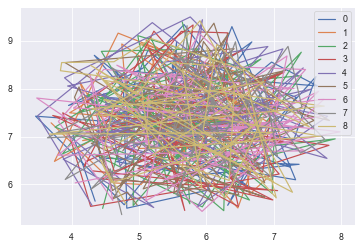

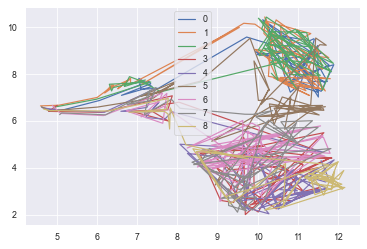

In [15]:
def plot_embeddings(embeddings):
    for idx, m_embeddings in enumerate(embeddings):
        plt.plot(m_embeddings[:,0], m_embeddings[:,1], label=str(idx))
    plt.legend()
    plt.show()
    plt.close()

plot_embeddings(train_embeddings)
plot_embeddings(test_embeddings)

In [3]:
def compute_rel_error(ref, pred):
    '''
    N is the number of initial conditions.
    M is the number of samples in prediction
    The first dimension "2" corresponds to position + velocity.
    B is the number of bodies.
    The last dimension "2" corresponds to xy.

    Arguments:
        ref: N x T x 2 x B x 2
        pred: M x N x T x 2 x B x 2
    '''
    delta_z = ref.unsqueeze(0) - pred  # M x N x T x 2 x B x 2
    all_err = delta_z.pow(2).sum(dim=-1).sum(dim=-1).sum(dim=-1).sqrt()  # M x N x T

    sum_z = ref.unsqueeze(0) + pred  # M x N x T x 2 x B x 2
    pred_rel_err = all_err / sum_z.pow(2).sum(dim=-1).sum(dim=-1).sum(dim=-1).sqrt()  # M x N x T

    return pred_rel_err

def compute_geom_mean(ts, values):
    '''Geometric mean of a continuous function over time.
    Arguments:
        ts: T
        values: ... x T
    '''
    t_range = ts.max() - ts.min()
    return torch.trapz((values + 1e-8).log(), ts).div(t_range).exp()  # ...

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


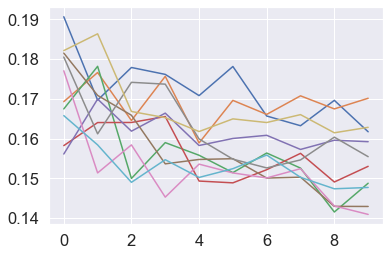

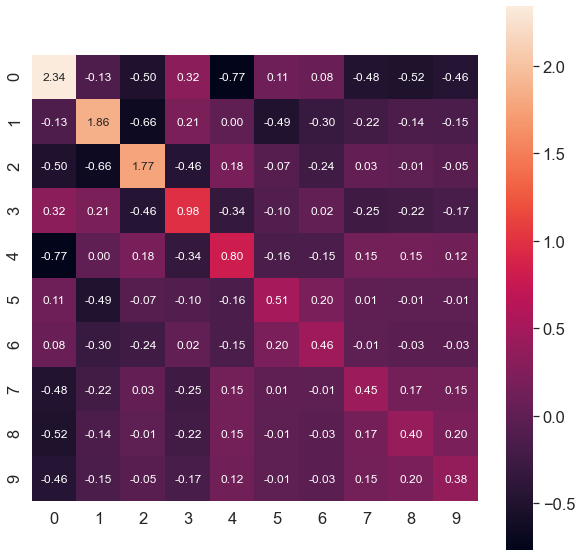

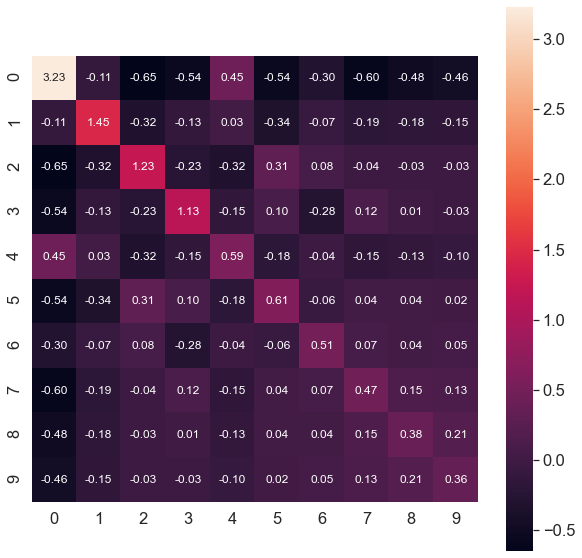

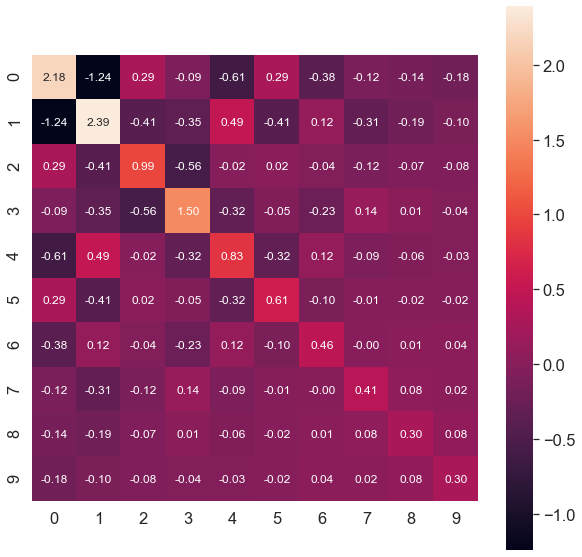

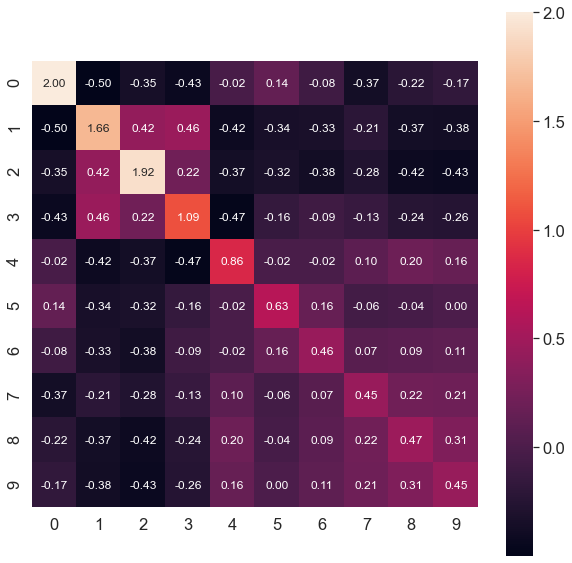

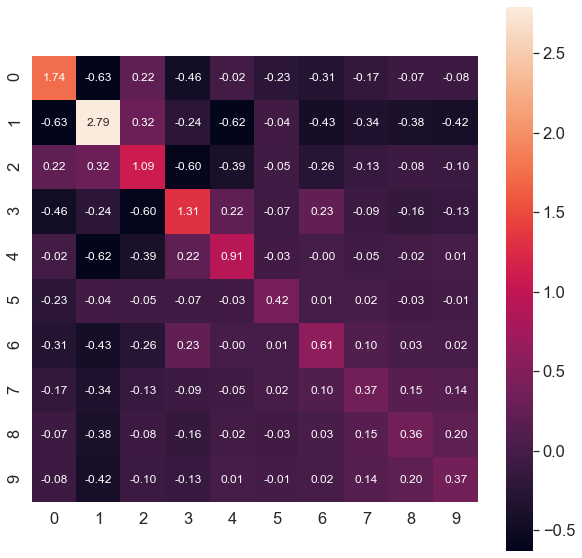

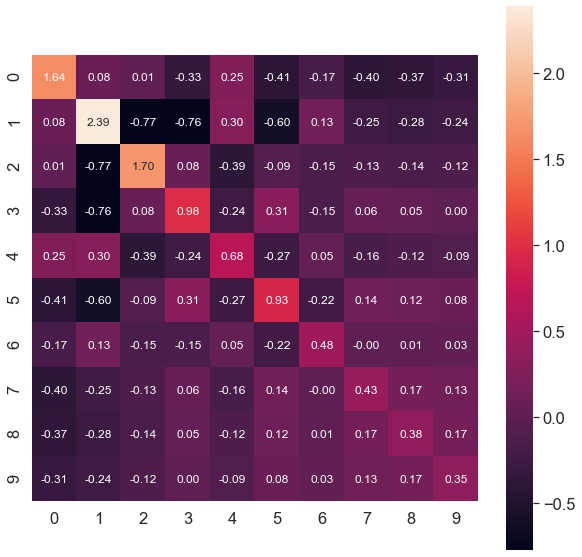

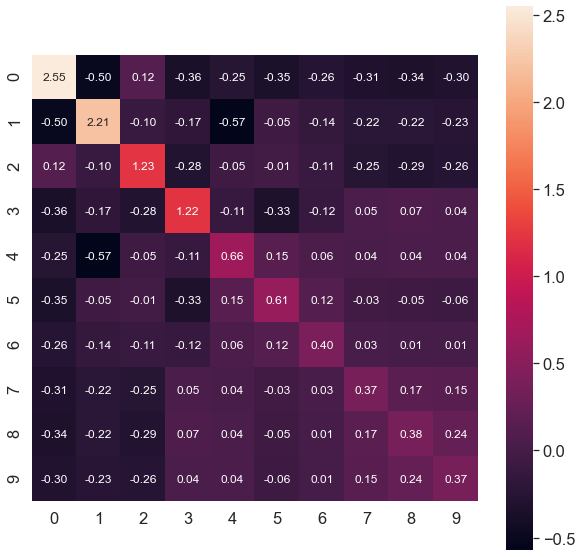

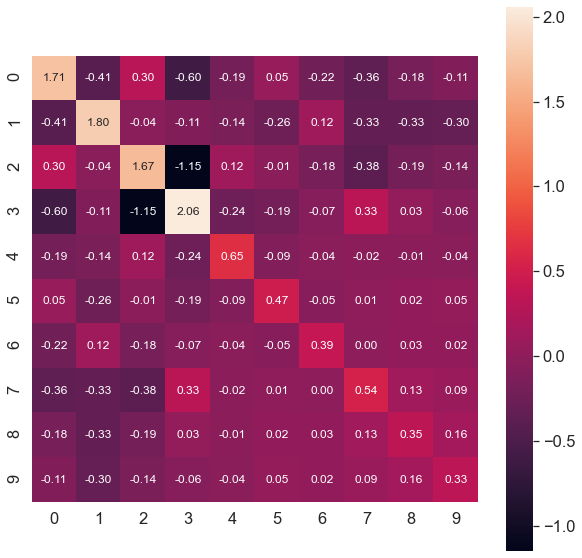

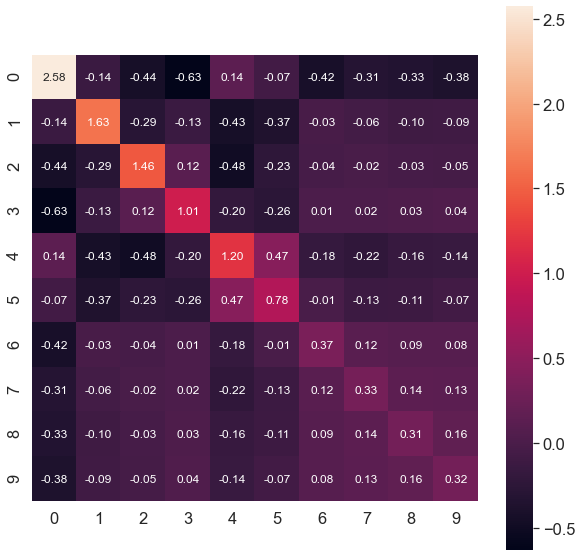

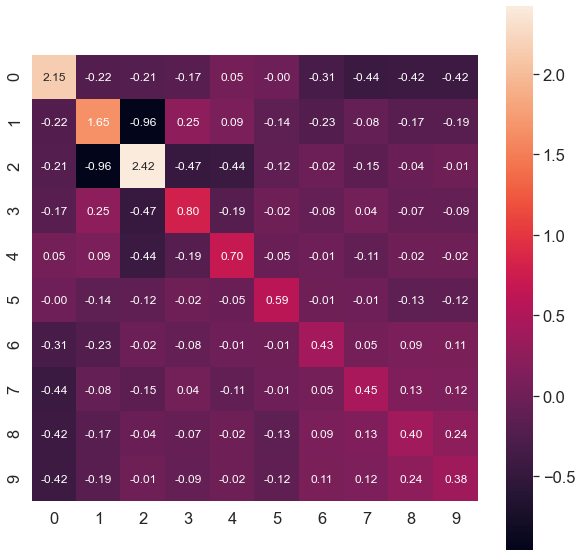

In [38]:
def compare_ensemble_indv_loss(true_zt, pred_zt, ts):
    means, stds = [], []
    for i in range(pred_zt.size(0)):
        rel_err = compute_rel_error(true_zt, pred_zt[i])
        err_geom_mean = compute_geom_mean(ts, rel_err)
        means.append(err_geom_mean.mean().item())
        stds.append(err_geom_mean.std().item())
    
    rel_err = compute_rel_error(true_zt, pred_zt.mean(0))
    err_geom_mean = compute_geom_mean(ts, rel_err)
    means.append(err_geom_mean.mean().item())
    stds.append(err_geom_mean.std().item())
    
    errs = [s / 5. for s in stds]
    
    labels = [str(i) for i in range(pred_zt.size(0))] + ["ensemble"]

    x = np.arange(len(labels))
    width = 0.5

    plt.bar(x - width/2, means, width, yerr=errs)#, label="hnn-de")
    plt.xticks(x, labels)
    plt.legend()

    plt.show()
    plt.close()

def correlation_of_errs(true_zt, pred_zt):
    num_models = pred_zt.size(0)
    errs = (true_zt - pred_zt).reshape(num_models, -1)
    scaled = StandardScaler().fit_transform(errs)
    cov = np.cov(scaled, rowvar=True)

    cols = [str(i) for i in range(len(cov))]
    plt.figure(figsize=cov.shape)
    sns.set(font_scale=1.5)
    hm = sns.heatmap(cov,
                     cbar=True,
                     annot=True,
                     square=True,
                     fmt='.2f',
                     annot_kws={'size': 12},
                     yticklabels=cols,
                     xticklabels=cols)
    
    plt.show()
    plt.close()
    
def get_ensemble_loss(ensemble, z0, ts, true_zt):
    pred_zt = []
    for idx, model in enumerate(ensemble):
        print(idx)
        model = model.to("cpu")
        with torch.no_grad():
            pred = model.integrate(z0, ts, method='rk4')    
        pred_zt.append(pred)
    pred_zt = torch.stack(pred_zt, dim=0).cpu()
    
#     compare_ensemble_indv_loss(true_zt, pred_zt, ts)
#     correlation_of_errs(true_zt, pred_zt)
    
    num_models = pred_zt.size(0)
    errs = (true_zt - pred_zt).reshape(num_models, -1)
    
    rel_err = compute_rel_error(true_zt, pred_zt)
    err_geom_mean = compute_geom_mean(ts, rel_err)
    
    return err_geom_mean.mean(1), errs

z0 = true_zt[:,0]

means, errs = [], []
for epoch_step in range(40,50):
    save_fn = "ensemble_epoch_{}.pt".format(5 * epoch_step)
    
    ensemble_dict = torch.load(save_fn)
    trainer.ensemble.load_state_dict(ensemble_dict)
    
    geom_mean, _errs = get_ensemble_loss(trainer.ensemble, z0, ts, true_zt)
    
    means.append(geom_mean)
    errs.append(_errs)

means = torch.stack(means, dim=1)
errs = torch.stack(errs, dim=1)

T = means.size(1)
for i in range(means.size(0)):
    plt.plot(range(T), means[i], label=str(i))
plt.show()
plt.close()

for i in range(means.size(0)):
    scaled = StandardScaler().fit_transform(errs[i])
    cov = np.cov(scaled, rowvar=True)

    cols = [str(i) for i in range(len(cov))]
    plt.figure(figsize=cov.shape)
    sns.set(font_scale=1.5)
    hm = sns.heatmap(cov,
                     cbar=True,
                     annot=True,
                     square=True,
                     fmt='.2f',
                     annot_kws={'size': 12},
                     yticklabels=cols,
                     xticklabels=cols)
    
    plt.show()
    plt.close()

In [24]:
true_zt.size()

torch.Size([25, 334, 2, 3, 2])

In [25]:
ts.size()

torch.Size([334])